In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import os
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unrar x "/content/drive/MyDrive/Train.rar" -idq

In [ ]:
def categorize_numbers(path):

  for i in range(10):                           #sakhtane folder ha
    if not os.path.exists( path + '/' + str(i) ):
      os.makedirs(path + '/' + str(i))
  files = os.listdir(path)

  for file in files:                             # enteghale file ha be folder ha
    if file.endswith('v'):
      file_path = os.path.join(path, file)
      new_path = path + '/' + file[0] + '/' + file
      os.replace(file_path, new_path)

In [ ]:
categorize_numbers("/content/Train")

In [ ]:
path = "/content/Train"
seed = 5
batch = 60
train_dt, valid_dt = tf.keras.utils.audio_dataset_from_directory(path, validation_split=0.13 ,subset="both", seed=seed, batch_size= batch)
train_dt.class_names

Found 15762 files belonging to 10 classes.
Using 13713 files for training.
Using 2049 files for validation.


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
def squeeze_by_avg(audio, labels):
  audio = tf.math.reduce_mean(audio, 2)
  return audio, labels

In [ ]:
train_dt = train_dt.map(squeeze_by_avg)
valid_dt = valid_dt.map(squeeze_by_avg)

In [ ]:
a, b = next(iter(train_dt))
np.shape(a)

TensorShape([60, 78992])

In [ ]:
def get_spectogram(voice, label):
  frame_length = 256
  frame_step = 128
  spect = tf.signal.stft(voice, frame_length= frame_length, frame_step= frame_step)
  spect = tf.abs(spect)
  spect = spect[... , tf.newaxis]
  return spect, label

In [ ]:
train_dt = train_dt.map(get_spectogram).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dt = valid_dt.map(get_spectogram).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
a, b = next(iter(valid_dt))
print(np.shape(a))
np.shape(b)

(60, 557, 129, 1)


TensorShape([60])

In [ ]:
a, b = next(iter(train_dt))
print(np.shape(a))
np.shape(b)

(60, 727, 129, 1)


TensorShape([60])

In [ ]:
Conv_kernel_size = (4,4)
strides = (2, 2)

In [ ]:
img_width = 256
img_height = 129
model = tf.keras.models.Sequential([

    layers.Resizing(img_width, img_height),
    layers.Normalization(),

    layers.Conv2D(256, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #1
    layers.Dropout(0.3),
    layers.Conv2D(256, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #2
    layers.Dropout(0.3),
    layers.Conv2D(256, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #3
    layers.Dropout(0.3),
    layers.Conv2D(128, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #4
    layers.Dropout(0.3),
    layers.Conv2D(128, Conv_kernel_size, padding = "same", activation = 'relu'),
    layers.MaxPool2D(),  #5
    layers.Dropout(0.3),

    layers.Reshape((img_width//32, (img_height//32)*128)),

    layers.Bidirectional(layers.GRU(512, dropout=0.5)),

    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(10)
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 256, 129, 1)       0         
                                                                 
 normalization_2 (Normaliza  (None, 256, 129, 1)       3         
 tion)                                                           
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 129, 256)     4352      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 128, 64, 256)      0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 128, 64, 256)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 64, 256)     

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
red_lr = keras.callbacks.ReduceLROnPlateau(
                                          monitor="val_loss",
                                          factor=0.1,
                                          patience=4,
                                          mode="auto",
                                          min_delta=0.0001,
                                          cooldown=0,
                                          min_lr=0.0
                                          )

In [ ]:
model.fit(train_dt,
          validation_data = valid_dt,
          epochs = 15,
          callbacks = [red_lr]
          )

Epoch 1/15
229/229 [==============================] - 319s 1s/step - loss: 1.7091 - accuracy: 0.3519 - val_loss: 1.1346 - val_accuracy: 0.5647 - lr: 0.0010
Epoch 2/15
229/229 [==============================] - 261s 1s/step - loss: 1.1495 - accuracy: 0.5520 - val_loss: 0.8702 - val_accuracy: 0.6554 - lr: 0.0010
Epoch 3/15
229/229 [==============================] - 261s 1s/step - loss: 0.9025 - accuracy: 0.6596 - val_loss: 0.7449 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 4/15
229/229 [==============================] - 260s 1s/step - loss: 0.7713 - accuracy: 0.7168 - val_loss: 0.5964 - val_accuracy: 0.7828 - lr: 0.0010
Epoch 5/15
229/229 [==============================] - 260s 1s/step - loss: 0.6755 - accuracy: 0.7522 - val_loss: 0.5494 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 6/15
229/229 [==============================] - 260s 1s/step - loss: 0.5969 - accuracy: 0.7928 - val_loss: 0.4121 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 7/15
229/229 [==============================] - 260s 1s/st

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dt,
          validation_data = valid_dt,
          epochs = 5
          )

Epoch 1/5
229/229 [==============================] - 265s 1s/step - loss: 0.2842 - accuracy: 0.9026 - val_loss: 0.2387 - val_accuracy: 0.9200
Epoch 2/5
229/229 [==============================] - 258s 1s/step - loss: 0.2598 - accuracy: 0.9083 - val_loss: 0.2295 - val_accuracy: 0.9219
Epoch 3/5
229/229 [==============================] - 258s 1s/step - loss: 0.2408 - accuracy: 0.9159 - val_loss: 0.2173 - val_accuracy: 0.9331
Epoch 4/5
229/229 [==============================] - 259s 1s/step - loss: 0.2247 - accuracy: 0.9196 - val_loss: 0.2152 - val_accuracy: 0.9317
Epoch 5/5
229/229 [==============================] - 263s 1s/step - loss: 0.2183 - accuracy: 0.9245 - val_loss: 0.2123 - val_accuracy: 0.9361


In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dt,
          validation_data = valid_dt,
          epochs = 5
          )

Epoch 1/5
229/229 [==============================] - 269s 1s/step - loss: 0.2187 - accuracy: 0.9250 - val_loss: 0.2106 - val_accuracy: 0.9385
Epoch 2/5
229/229 [==============================] - 260s 1s/step - loss: 0.2037 - accuracy: 0.9290 - val_loss: 0.2060 - val_accuracy: 0.9380
Epoch 3/5
229/229 [==============================] - 260s 1s/step - loss: 0.1996 - accuracy: 0.9301 - val_loss: 0.2064 - val_accuracy: 0.9390
Epoch 4/5
229/229 [==============================] - 259s 1s/step - loss: 0.1903 - accuracy: 0.9333 - val_loss: 0.2076 - val_accuracy: 0.9341
Epoch 5/5
229/229 [==============================] - 259s 1s/step - loss: 0.1830 - accuracy: 0.9350 - val_loss: 0.2041 - val_accuracy: 0.9414


In [ ]:
model.fit(train_dt,
          validation_data = valid_dt,
          epochs = 5
          )

Epoch 1/5
229/229 [==============================] - 260s 1s/step - loss: 0.1866 - accuracy: 0.9343 - val_loss: 0.2101 - val_accuracy: 0.9380
Epoch 2/5
229/229 [==============================] - 260s 1s/step - loss: 0.1798 - accuracy: 0.9349 - val_loss: 0.2024 - val_accuracy: 0.9419
Epoch 3/5
229/229 [==============================] - 260s 1s/step - loss: 0.1755 - accuracy: 0.9391 - val_loss: 0.1927 - val_accuracy: 0.9414
Epoch 4/5
229/229 [==============================] - 260s 1s/step - loss: 0.1712 - accuracy: 0.9390 - val_loss: 0.2012 - val_accuracy: 0.9405
Epoch 5/5
229/229 [==============================] - 265s 1s/step - loss: 0.1774 - accuracy: 0.9371 - val_loss: 0.1923 - val_accuracy: 0.9395


In [ ]:
model.save_weights("/content/drive/MyDrive/Persian_Numbers_Model_Weights.h5")

In [ ]:
!unrar x "/content/drive/MyDrive/Test.rar" -idq

In [ ]:
categorize_numbers("/content/Test")

In [ ]:
path = "/content/Test"
test_dt = tf.keras.utils.audio_dataset_from_directory(path, seed=seed)
class_names = test_dt.class_names
test_dt = test_dt.map(squeeze_by_avg)
test_dt = test_dt.map(get_spectogram)

Found 1151 files belonging to 10 classes.


In [ ]:
model.evaluate(test_dt)

36/36 [==============================] - 4s 102ms/step - loss: 0.3905 - accuracy: 0.8862


[0.39050087332725525, 0.8861859440803528]

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dt:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch, verbose=0)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

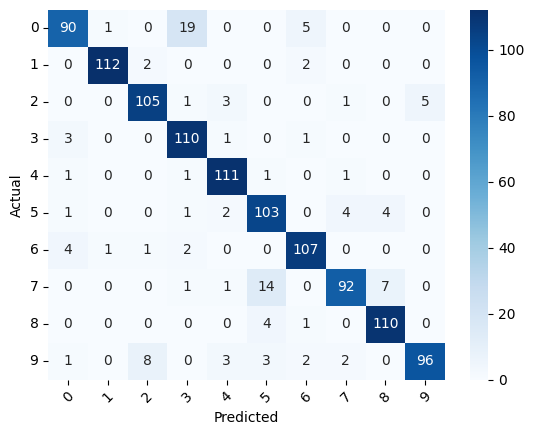

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(class_names))+0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names))+0.5, class_names, rotation=0)
plt.show()